## Practical Example: Grid World

In the example from the notebook, Q-learning is applied to a grid world where:
- The agent navigates a 4×4 grid
- Terminal states are at (0,0) with reward 1 and (3,3) with reward 10
- All other states have reward 0
- The agent can move up, down, left, or right
- The goal is to learn the optimal path to the highest reward

As the agent explores, it updates its Q-values and gradually learns the best path through the environment. The visualization shows how the agent starts by exploring randomly and eventually converges on the optimal policy.

# Setting up the Environment
Import necessary libraries including NumPy for numerical operations and Matplotlib for visualizations.

In [1]:
# Import necessary libraries
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For visualizations

# Import type hints
from typing import List, Tuple, Dict, Optional

# set seed for reproducibility
np.random.seed(42)

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Creating a Simple Environment

To create a simple environment for the Q-learning algorithm, we will define a 4x4 GridWorld. The GridWorld will have the following properties:
    
- 4 rows and 4 columns
- Possible actions: 'up', 'down', 'left', 'right'

In [2]:
# Define the GridWorld environment
def create_gridworld(
    rows: int,
    cols: int,
    terminal_states: List[Tuple[int, int]],
    rewards: Dict[Tuple[int, int], int]
) -> Tuple[np.ndarray, List[Tuple[int, int]], List[str]]:
    """
    Create a simple GridWorld environment.

    Parameters:
    - rows (int): Number of rows in the grid.
    - cols (int): Number of columns in the grid.
    - terminal_states (List[Tuple[int, int]]): List of terminal states as (row, col) tuples.
    - rewards (Dict[Tuple[int, int], int]): Dictionary mapping (row, col) to reward values.

    Returns:
    - grid (np.ndarray): A 2D array representing the grid with rewards.
    - state_space (List[Tuple[int, int]]): List of all possible states in the grid.
    - action_space (List[str]): List of possible actions ('up', 'down', 'left', 'right').
    """
    # Initialize the grid with zeros
    grid = np.zeros((rows, cols))

    # Assign rewards to specified states
    for (row, col), reward in rewards.items():
        grid[row, col] = reward

    # Define the state space as all possible (row, col) pairs
    state_space = [
        (row, col)
        for row in range(rows)
        for col in range(cols)
    ]

    # Define the action space as the four possible movements
    action_space = ['up', 'down', 'left', 'right']

    return grid, state_space, action_space


Next we need to state transition function, which takes the current state and action as input and returns the next state. Think of this as the agent moving around the grid based on the action it takes.

In [3]:
# Define state transition function
def state_transition(state: Tuple[int, int], action: str, rows: int, cols: int) -> Tuple[int, int]:
    """
    Compute the next state given the current state and action.

    Parameters:
    - state (Tuple[int, int]): Current state as (row, col).
    - action (str): Action to take ('up', 'down', 'left', 'right').
    - rows (int): Number of rows in the grid.
    - cols (int): Number of columns in the grid.

    Returns:
    - Tuple[int, int]: The resulting state (row, col) after taking the action.
    """
    # Unpack the current state into row and column
    row, col = state

    # Update the row or column based on the action, ensuring boundaries are respected
    if action == 'up' and row > 0:  # Move up if not in the topmost row
        row -= 1
    elif action == 'down' and row < rows - 1:  # Move down if not in the bottommost row
        row += 1
    elif action == 'left' and col > 0:  # Move left if not in the leftmost column
        col -= 1
    elif action == 'right' and col < cols - 1:  # Move right if not in the rightmost column
        col += 1

    # Return the new state as a tuple
    return (row, col)


Now that our agent can interact with the environment, we need to define the reward function. This function will return the reward for a given state, which will be used to update the Q-values during training.

In [4]:
# Define reward function
def get_reward(state: Tuple[int, int], rewards: Dict[Tuple[int, int], int]) -> int:
    """
    Get the reward for a given state.

    Parameters:
    - state (Tuple[int, int]): Current state as (row, col).
    - rewards (Dict[Tuple[int, int], int]): Dictionary mapping (row, col) to reward values.

    Returns:
    - int: The reward for the given state. Returns 0 if the state is not in the rewards dictionary.
    """
    # Use the rewards dictionary to fetch the reward for the given state.
    # If the state is not found, return a default reward of 0.
    return rewards.get(state, 0)

Now that we have defined the GridWorld environment and the necessary helper functions, let's test them with a simple example. We will create a 4x4 grid with two terminal states at (0, 0) and (3, 3) having rewards of 1 and 10, respectively. We will then test the state transition and reward functions by moving from the state (2, 2) upwards.

In [5]:
# Example usage of the GridWorld environment

# Define the grid dimensions (4x4), terminal states, and rewards
rows, cols = 4, 4  # Number of rows and columns in the grid
terminal_states = [(0, 0), (3, 3)]  # Terminal states with rewards
rewards = {(0, 0): 1, (3, 3): 10}  # Rewards for terminal states

# Create the GridWorld environment
grid, state_space, action_space = create_gridworld(rows, cols, terminal_states, rewards)

# Test the state transition and reward functions
current_state = (2, 2)  # Starting state
action = 'up'  # Action to take
next_state = state_transition(current_state, action, rows, cols)  # Compute the next state
reward = get_reward(next_state, rewards)  # Get the reward for the next state

# Print the results
print("GridWorld:")  # Display the grid with rewards
print(grid)
print(f"Current State: {current_state}")  # Display the current state
print(f"Action Taken: {action}")  # Display the action taken
print(f"Next State: {next_state}")  # Display the resulting next state
print(f"Reward: {reward}")  # Display the reward for the next state

GridWorld:
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0. 10.]]
Current State: (2, 2)
Action Taken: up
Next State: (1, 2)
Reward: 0


You can see that the GridWorld environment is created with the specified dimensions, terminal states, and rewards. We randomly selected a starting state (2, 2) and an action ('up') to take. The next state is computed as (1, 2) with a reward of 0 because our terminal_states dictionary does not contain this state.

# Implementing the Q-Learning Algorithm

So, we have successfully implemented the GridWorld environment with state transition and reward functions. We can now use this environment to implement the Q-learning algorithm. We first need to initialize the Q-table, which is a dictionary mapping state-action pairs to Q-values. The Q-value represents the expected cumulative reward when taking a specific action in a given state.

In [6]:
# Initialize Q-table
def initialize_q_table(state_space: List[Tuple[int, int]], action_space: List[str]) -> Dict[Tuple[int, int], Dict[str, float]]:
    """
    Initialize the Q-table with zeros for all state-action pairs.

    Parameters:
    - state_space (List[Tuple[int, int]]): List of all possible states in the environment, represented as (row, col) tuples.
    - action_space (List[str]): List of all possible actions (e.g., 'up', 'down', 'left', 'right').

    Returns:
    - q_table (Dict[Tuple[int, int], Dict[str, float]]): A dictionary where each state maps to another dictionary.
      The inner dictionary maps each action to its corresponding Q-value, initialized to 0.
    """
    q_table: Dict[Tuple[int, int], Dict[str, float]] = {}
    for state in state_space:
        # Initialize Q-values for all actions in the given state to 0
        q_table[state] = {action: 0.0 for action in action_space}
    return q_table


Next, we define the functions for choosing an action using the epsilon-greedy policy, if random values are less than epsilon, we choose a random action, otherwise, we choose the action with the highest Q-value for the current state.

In [7]:
# Choose action using epsilon-greedy policy
def choose_action(state: Tuple[int, int], q_table: Dict[Tuple[int, int], Dict[str, float]], action_space: List[str], epsilon: float) -> str:
    """
    Choose an action using the epsilon-greedy policy.

    Parameters:
    - state (Tuple[int, int]): Current state as (row, col).
    - q_table (Dict[Tuple[int, int], Dict[str, float]]): Q-table mapping state-action pairs to Q-values.
    - action_space (List[str]): List of possible actions (e.g., 'up', 'down', 'left', 'right').
    - epsilon (float): Exploration rate (0 <= epsilon <= 1).

    Returns:
    - str: The chosen action.
    """
    # With probability epsilon, choose a random action (exploration)
    if np.random.rand() < epsilon:
        return np.random.choice(action_space)
    # Otherwise, choose the action with the highest Q-value for the current state (exploitation)
    else:
        return max(q_table[state], key=q_table[state].get)


Once we take the action and observe the reward and next state, we can update the Q-value using the Q-learning update rule. The update rule is given by:
$$
Q(s, a) = Q(s, a) + α * [R(s) + γ * max(Q(s', a')) - Q(s, a)]
$$

In [8]:
# Update Q-value
def update_q_value(
    q_table: Dict[Tuple[int, int], Dict[str, float]],
    state: Tuple[int, int],
    action: str,
    reward: int,
    next_state: Tuple[int, int],
    alpha: float,
    gamma: float,
    action_space: List[str]
) -> None:
    """
    Update the Q-value using the Q-learning update rule.

    Parameters:
    - q_table (Dict[Tuple[int, int], Dict[str, float]]): Q-table mapping state-action pairs to Q-values.
    - state (Tuple[int, int]): Current state as (row, col).
    - action (str): Action taken.
    - reward (int): Reward received.
    - next_state (Tuple[int, int]): Next state as (row, col).
    - alpha (float): Learning rate (0 < alpha <= 1).
    - gamma (float): Discount factor (0 <= gamma <= 1).
    - action_space (List[str]): List of possible actions.

    Returns:
    - None: Updates the Q-table in place.
    """
    # Get the maximum Q-value for the next state across all possible actions
    max_next_q: float = max(q_table[next_state].values()) if next_state in q_table else 0.0

    # Update the Q-value for the current state-action pair using the Q-learning formula
    q_table[state][action] += alpha * (reward + gamma * max_next_q - q_table[state][action])


So far, we have defined the GridWorld environment, the state transition function, the reward function, and the Q-learning update rule. We have also implemented the Q-table initialization, action selection using the epsilon-greedy policy, and the Q-value update function. Now, we can put everything together to run multiple episodes of Q-learning in the GridWorld environment.

In [9]:
# Run a single episode
def run_episode(
    q_table: Dict[Tuple[int, int], Dict[str, float]],
    state_space: List[Tuple[int, int]],
    action_space: List[str],
    rewards: Dict[Tuple[int, int], int],
    rows: int,
    cols: int,
    alpha: float,
    gamma: float,
    epsilon: float,
    max_steps: int
) -> int:
    """
    Run a single episode of Q-learning.

    Parameters:
    - q_table (Dict[Tuple[int, int], Dict[str, float]]): Q-table mapping state-action pairs to Q-values.
    - state_space (List[Tuple[int, int]]): List of all possible states in the environment.
    - action_space (List[str]): List of possible actions (e.g., 'up', 'down', 'left', 'right').
    - rewards (Dict[Tuple[int, int], int]): Dictionary mapping states (row, col) to reward values.
    - rows (int): Number of rows in the grid.
    - cols (int): Number of columns in the grid.
    - alpha (float): Learning rate (0 < alpha <= 1).
    - gamma (float): Discount factor (0 <= gamma <= 1).
    - epsilon (float): Exploration rate (0 <= epsilon <= 1).
    - max_steps (int): Maximum number of steps allowed in the episode.

    Returns:
    - int: Total reward accumulated during the episode.
    """
    # Start from a random state
    state: Tuple[int, int] = state_space[np.random.choice(len(state_space))]
    total_reward: int = 0  # Initialize total reward for the episode

    # Loop for a maximum number of steps
    for _ in range(max_steps):
        # Choose an action using the epsilon-greedy policy
        action: str = choose_action(state, q_table, action_space, epsilon)

        # Compute the next state based on the chosen action
        next_state: Tuple[int, int] = state_transition(state, action, rows, cols)

        # Get the reward for the next state
        reward: int = get_reward(next_state, rewards)

        # Update the Q-value for the current state-action pair
        update_q_value(q_table, state, action, reward, next_state, alpha, gamma, action_space)

        # Accumulate the reward
        total_reward += reward

        # Move to the next state
        state = next_state

        # Check if the agent has reached a terminal state
        if state in terminal_states:
            break

    # Return the total reward accumulated during the episode
    return total_reward


We can now run multiple episodes of Q-learning to train the agent in the GridWorld environment. We will track the total reward accumulated in each episode and visualize the rewards over time using a line plot.

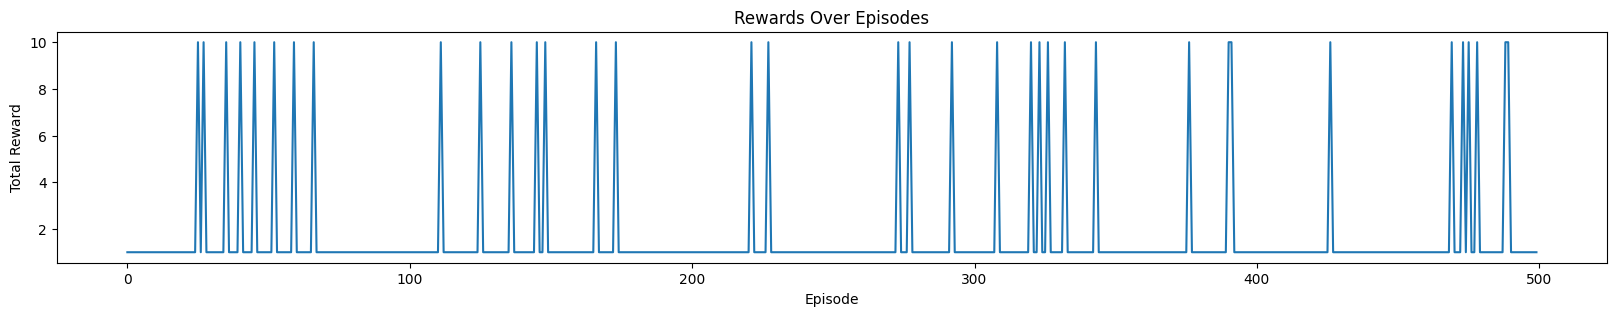

In [10]:
# Set hyperparameters for the Q-learning algorithm
alpha = 0.1  # Learning rate: Determines how much new information overrides old information
gamma = 0.9  # Discount factor: Determines the importance of future rewards
epsilon = 0.1  # Exploration rate: Probability of choosing a random action (exploration vs. exploitation)
max_steps = 100  # Maximum number of steps allowed per episode
episodes = 500  # Total number of episodes to run

# Initialize the Q-table with zeros for all state-action pairs
q_table = initialize_q_table(state_space, action_space)

# List to store the total reward accumulated in each episode
rewards_per_episode = []

# Run multiple episodes of Q-learning
for episode in range(episodes):
    # Run a single episode and get the total reward
    total_reward = run_episode(q_table, state_space, action_space, rewards, rows, cols, alpha, gamma, epsilon, max_steps)
    # Append the total reward for this episode to the rewards list
    rewards_per_episode.append(total_reward)

# Adjust figure size for better visibility
plt.figure(figsize=(20, 3))

# Plot the total rewards accumulated over episodes
plt.plot(rewards_per_episode)
plt.xlabel('Episode')  # Label for the x-axis
plt.ylabel('Total Reward')  # Label for the y-axis
plt.title('Rewards Over Episodes')  # Title of the plot
plt.show()  # Display the plot

**Observed Learning Behavior:**

- **Early episodes**: Mostly zero rewards, meaning the agent is exploring.
- **Later episodes**: High reward spikes suggest the agent finds the goal sometimes but inconsistently.
- **Fluctuations**: Indicate the policy is not yet stable.

# Q-Table Initialization and Updates
Implement functions to initialize and update the Q-table based on experiences, using the Q-Learning update rule.

In [11]:
# Initialize Q-table
def initialize_q_table(state_space, action_space):
    """
    Initialize the Q-table with zeros.

    Parameters:
    - state_space: List of all possible states.
    - action_space: List of possible actions.

    Returns:
    - q_table: A dictionary mapping state-action pairs to Q-values.
    """
    q_table = {}
    for state in state_space:
        q_table[state] = {action: 0 for action in action_space}
    return q_table

# Choose action using epsilon-greedy policy
def choose_action(state, q_table, action_space, epsilon):
    """
    Choose an action using the epsilon-greedy policy.

    Parameters:
    - state: Current state as (row, col).
    - q_table: Q-table mapping state-action pairs to Q-values.
    - action_space: List of possible actions.
    - epsilon: Exploration rate.

    Returns:
    - action: The chosen action.
    """
    if np.random.rand() < epsilon:
        return np.random.choice(action_space)  # Explore
    else:
        return max(q_table[state], key=q_table[state].get)  # Exploit

# Update Q-value
def update_q_value(q_table, state, action, reward, next_state, alpha, gamma, action_space):
    """
    Update the Q-value using the Q-learning update rule.

    Parameters:
    - q_table: Q-table mapping state-action pairs to Q-values.
    - state: Current state as (row, col).
    - action: Action taken.
    - reward: Reward received.
    - next_state: Next state as (row, col).
    - alpha: Learning rate.
    - gamma: Discount factor.
    - action_space: List of possible actions.

    Returns:
    - None (updates q_table in place).
    """
    max_next_q = max(q_table[next_state].values()) if next_state in q_table else 0
    q_table[state][action] += alpha * (reward + gamma * max_next_q - q_table[state][action])

# Exploration vs. Exploitation Strategy
Now to properly use the exploration vs. exploitation strategy, we need to implement it properly. The first function is the epsilon-greedy policy, which chooses an action based on the epsilon value.

In [12]:
# Define epsilon-greedy policy
def epsilon_greedy_policy(
    q_table: Dict[Tuple[int, int], Dict[str, float]],
    state: Tuple[int, int],
    action_space: List[str],
    epsilon: float
) -> str:
    """
    Implement the epsilon-greedy policy for action selection.

    Parameters:
    - q_table (Dict[Tuple[int, int], Dict[str, float]]): Q-table mapping state-action pairs to Q-values.
    - state (Tuple[int, int]): Current state as (row, col).
    - action_space (List[str]): List of possible actions.
    - epsilon (float): Exploration rate.

    Returns:
    - str: The chosen action.
    """
    # With probability epsilon, choose a random action (exploration)
    if np.random.rand() < epsilon:
        return np.random.choice(action_space)
    # Otherwise, choose the action with the highest Q-value for the current state (exploitation)
    else:
        return max(q_table[state], key=q_table[state].get)

The second function is the dynamic epsilon adjustment, which adjusts the epsilon value over time to balance exploration and exploitation.

In [13]:
# Define dynamic epsilon adjustment
def adjust_epsilon(
    initial_epsilon: float,
    min_epsilon: float,
    decay_rate: float,
    episode: int
) -> float:
    """
    Dynamically adjust epsilon over time to balance exploration and exploitation.

    Parameters:
    - initial_epsilon (float): Initial exploration rate.
    - min_epsilon (float): Minimum exploration rate.
    - decay_rate (float): Rate at which epsilon decays.
    - episode (int): Current episode number.

    Returns:
    - float: Adjusted exploration rate.
    """
    # Compute the decayed epsilon value, ensuring it doesn't go below the minimum epsilon
    return max(min_epsilon, initial_epsilon * np.exp(-decay_rate * episode))

Finally, we can use these functions to track the epsilon values over episodes and plot the decay.

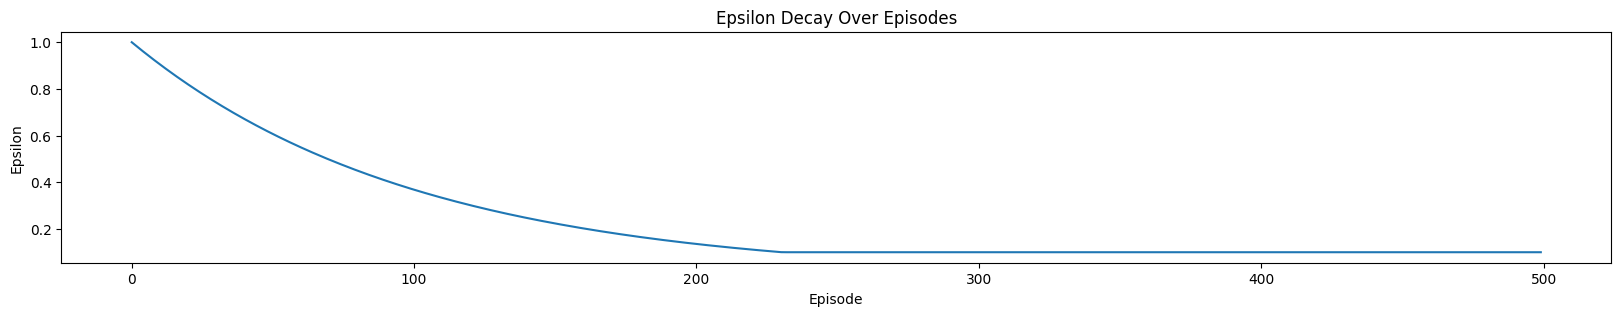

In [14]:
# Example usage of epsilon-greedy policy and dynamic epsilon adjustment
initial_epsilon: float = 1.0  # Start with full exploration
min_epsilon: float = 0.1  # Minimum exploration rate
decay_rate: float = 0.01  # Decay rate for epsilon
episodes: int = 500  # Number of episodes

# Track epsilon values over episodes
epsilon_values: List[float] = []
for episode in range(episodes):
    # Adjust epsilon for the current episode
    epsilon = adjust_epsilon(initial_epsilon, min_epsilon, decay_rate, episode)
    epsilon_values.append(epsilon)

# Adjust figure size for better visibility
plt.figure(figsize=(20, 3))

# Plot epsilon decay over episodes
plt.plot(epsilon_values)
plt.xlabel('Episode')  # Label for the x-axis
plt.ylabel('Epsilon')  # Label for the y-axis
plt.title('Epsilon Decay Over Episodes')  # Title of the plot
plt.show()  # Display the plot

1. **Early Exploration (High Epsilon ~1.0)**  
   - In the first **100-150 episodes**, the agent moves **randomly** due to high epsilon.  
   - It explores various paths, including **suboptimal ones**, which is why we saw low rewards in your reward graph.  

2. **Midway Transition (Epsilon Decaying)**  
   - Around episode **150-250**, epsilon decreases, and the agent starts **favoring better actions** while still exploring.  
   - This aligns with the **first appearance of high rewards** in your reward graph—meaning the agent **occasionally finds the goal**.  

3. **Late Exploitation (Epsilon Plateauing ~0.1)**  
   - After **250+ episodes**, epsilon is very low, meaning the agent **mostly follows the best-known path**.  
   - Your reward graph shows **sporadic high rewards**, indicating the agent has **learned the goal but isn’t 100% consistent** yet.  

**What This Means for our GridWorld Training**  
- **Epsilon decay helped the agent learn**—it first explored widely, then refined its strategy.  
- **Unstable high rewards suggest** the agent still struggles with finding the goal consistently.  
- **Possible Fix:** Try a **slower epsilon decay** or an **adaptive schedule** to improve learning stability.  

# Running the Q-Learning Algorithm
Let's run the Q-learning algorithm in the GridWorld environment and visualize the Q-values learned by the agent. We will plot the Q-values for each state-action pair over time to see how they evolve during training.

In [15]:
# Execute the Q-Learning algorithm over multiple episodes and track performance metrics
def run_q_learning(
    q_table: Dict[Tuple[int, int], Dict[str, float]],
    state_space: List[Tuple[int, int]],
    action_space: List[str],
    rewards: Dict[Tuple[int, int], int],
    rows: int,
    cols: int,
    alpha: float,
    gamma: float,
    initial_epsilon: float,
    min_epsilon: float,
    decay_rate: float,
    episodes: int,
    max_steps: int
) -> Tuple[List[int], List[int]]:
    """
    Execute the Q-Learning algorithm over multiple episodes.

    Parameters:
    - q_table: Q-table mapping state-action pairs to Q-values.
    - state_space: List of all possible states.
    - action_space: List of possible actions.
    - rewards: Dictionary mapping (row, col) to reward values.
    - rows: Number of rows in the grid.
    - cols: Number of columns in the grid.
    - alpha: Learning rate.
    - gamma: Discount factor.
    - initial_epsilon: Initial exploration rate.
    - min_epsilon: Minimum exploration rate.
    - decay_rate: Rate at which epsilon decays.
    - episodes: Number of episodes to run.
    - max_steps: Maximum number of steps per episode.

    Returns:
    - rewards_per_episode: List of total rewards per episode.
    - episode_lengths: List of episode lengths.
    """
    # Initialize lists to store metrics
    rewards_per_episode: List[int] = []
    episode_lengths: List[int] = []

    # Loop through each episode
    for episode in range(episodes):
        # Start from a random state
        state: Tuple[int, int] = state_space[np.random.choice(len(state_space))]
        total_reward: int = 0  # Initialize total reward for the episode
        steps: int = 0  # Initialize step counter
        # Adjust epsilon for the current episode
        epsilon: float = adjust_epsilon(initial_epsilon, min_epsilon, decay_rate, episode)

        # Loop for a maximum number of steps
        for _ in range(max_steps):
            # Choose an action using the epsilon-greedy policy
            action: str = epsilon_greedy_policy(q_table, state, action_space, epsilon)
            # Compute the next state based on the chosen action
            next_state: Tuple[int, int] = state_transition(state, action, rows, cols)
            # Get the reward for the next state
            reward: int = get_reward(next_state, rewards)
            # Update the Q-value for the current state-action pair
            update_q_value(q_table, state, action, reward, next_state, alpha, gamma, action_space)
            # Accumulate the reward
            total_reward += reward
            # Move to the next state
            state = next_state
            # Increment the step counter
            steps += 1
            # Check if the agent has reached a terminal state
            if state in terminal_states:
                break

        # Append metrics for the current episode
        rewards_per_episode.append(total_reward)
        episode_lengths.append(steps)

    # Return the metrics
    return rewards_per_episode, episode_lengths

So we will be running the Q-Learning algorithm over `500` episodes with a maximum of `100` steps per episode. Let's execute the algorithm and visualize the results.

In [16]:
# Set hyperparameters for Q-Learning
alpha: float = 0.1  # Learning rate
gamma: float = 0.9  # Discount factor
initial_epsilon: float = 1.0  # Initial exploration rate
min_epsilon: float = 0.1  # Minimum exploration rate
decay_rate: float = 0.01  # Decay rate for epsilon
episodes: int = 500  # Number of episodes
max_steps: int = 100  # Maximum steps per episode

# Initialize the Q-table
q_table: Dict[Tuple[int, int], Dict[str, float]] = initialize_q_table(state_space, action_space)

# Execute the Q-Learning algorithm
rewards_per_episode, episode_lengths = run_q_learning(
    q_table, state_space, action_space, rewards, rows, cols, alpha, gamma,
    initial_epsilon, min_epsilon, decay_rate, episodes, max_steps
)

Let's visualize our training process by plotting the total rewards accumulated over episodes and the episode lengths.

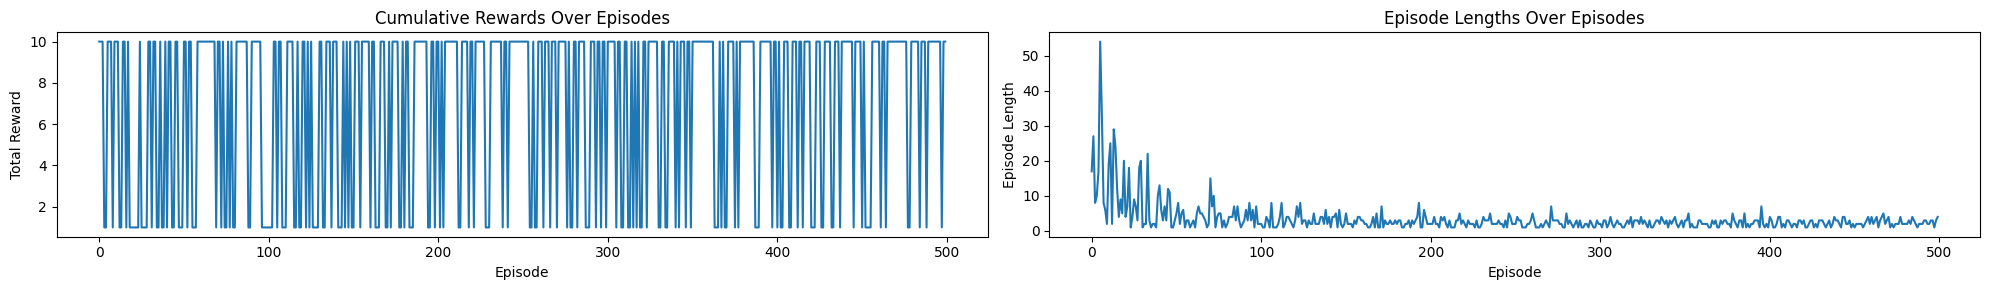

In [17]:
# Plot cumulative rewards over episodes
plt.figure(figsize=(20, 3))

# Plot total rewards per episode
plt.subplot(1, 2, 1)
plt.plot(rewards_per_episode)
plt.xlabel('Episode')  # Label for the x-axis
plt.ylabel('Total Reward')  # Label for the y-axis
plt.title('Cumulative Rewards Over Episodes')  # Title of the plot

# Plot episode lengths per episode
plt.subplot(1, 2, 2)
plt.plot(episode_lengths)
plt.xlabel('Episode')  # Label for the x-axis
plt.ylabel('Episode Length')  # Label for the y-axis
plt.title('Episode Lengths Over Episodes')  # Title of the plot

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

Let's break it down:

**Left Graph: Cumulative Rewards Over Episodes**
- The **total reward per episode fluctuates** early on, showing a mix of successes and failures.  
- **Later episodes consistently achieve the maximum reward (10),** indicating that the agent has learned an optimal policy.  
- Some low-reward episodes still appear, suggesting occasional suboptimal exploration or stochastic behavior.  

**Relation to GridWorld:**
- The agent is moving toward **(3,3), which provides a reward of 10**.
- Initially, it explores inefficient paths, leading to varied rewards.
- Over time, it finds **shorter, more optimal routes**.

**Right Graph: Episode Lengths Over Episodes**
- **Early episodes have longer lengths (up to 50 steps),** meaning the agent took inefficient routes.
- As training progresses, the **episode length decreases**, indicating the agent finds the goal **faster**.
- **Most episodes stabilize at a low step count (~3-6 steps),** meaning the agent has optimized its path.

**Relation to GridWorld:**
- The GridWorld is only **4x4 (16 states),** so an optimal policy should solve it quickly.
- Initially, the agent took **random or exploratory moves**, increasing step count.
- Once Q-values converge, the agent **chooses direct routes to the goal**, reducing steps.

# Visualizing the Learning Process

We need to visualize what actually is happening in the Q-table. We can visualize the Q-values as heatmaps for each action and the learned policy as arrows on the grid. Let's define some visualization functions to help us with this.

In [18]:
# Function to visualize the Q-value heatmap
def plot_q_values(q_table: Dict[Tuple[int, int], Dict[str, float]], rows: int, cols: int, action_space: List[str]) -> None:
    """
    Visualize the Q-values as a heatmap for each action.

    Parameters:
    - q_table (Dict[Tuple[int, int], Dict[str, float]]): Q-table mapping state-action pairs to Q-values.
    - rows (int): Number of rows in the grid.
    - cols (int): Number of columns in the grid.
    - action_space (List[str]): List of possible actions.

    Returns:
    - None: Displays heatmaps for Q-values of each action.
    """
    # Create subplots for each action
    fig, axes = plt.subplots(1, len(action_space), figsize=(15, 5))
    for i, action in enumerate(action_space):
        # Initialize a grid to store Q-values for the current action
        q_values = np.zeros((rows, cols))
        for (row, col), actions in q_table.items():
            q_values[row, col] = actions[action]  # Extract Q-value for the current action

        # Plot the heatmap for the current action
        ax = axes[i]
        cax = ax.matshow(q_values, cmap='viridis')
        fig.colorbar(cax, ax=ax)
        ax.set_title(f"Q-values for action: {action}")
        ax.set_xlabel("Columns")
        ax.set_ylabel("Rows")

    # Adjust layout and display the heatmaps
    plt.tight_layout()
    plt.show()

In [19]:
# Function to visualize the learned policy
def plot_policy(q_table: Dict[Tuple[int, int], Dict[str, float]], rows: int, cols: int) -> None:
    """
    Visualize the learned policy as arrows on the grid.

    Parameters:
    - q_table (Dict[Tuple[int, int], Dict[str, float]]): Q-table mapping state-action pairs to Q-values.
    - rows (int): Number of rows in the grid.
    - cols (int): Number of columns in the grid.

    Returns:
    - None: Displays the policy visualization.
    """
    # Initialize a grid to store the best action for each state
    policy_grid = np.empty((rows, cols), dtype=str)
    action_symbols = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}  # Symbols for actions

    # Determine the best action for each state based on Q-values
    for (row, col), actions in q_table.items():
        best_action = max(actions, key=actions.get)  # Get the action with the highest Q-value
        policy_grid[row, col] = action_symbols[best_action]  # Map the action to its symbol

    # Plot the policy grid with increased width
    fig, ax = plt.subplots(figsize=(16, 3))  # Increased width from 12 to 16 for more horizontal stretch
    for i in range(rows):
        for j in range(cols):
            ax.text(j, i, policy_grid[i, j], ha='center', va='center', fontsize=14)  # Slightly larger font

    # Create a wider grid with more horizontal space
    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(-0.5, rows - 0.5)
    ax.matshow(np.zeros((rows, cols)), cmap='Greys', alpha=0.1)  # Add a faint background grid
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title("Learned Policy")
    plt.tight_layout()
    plt.show()

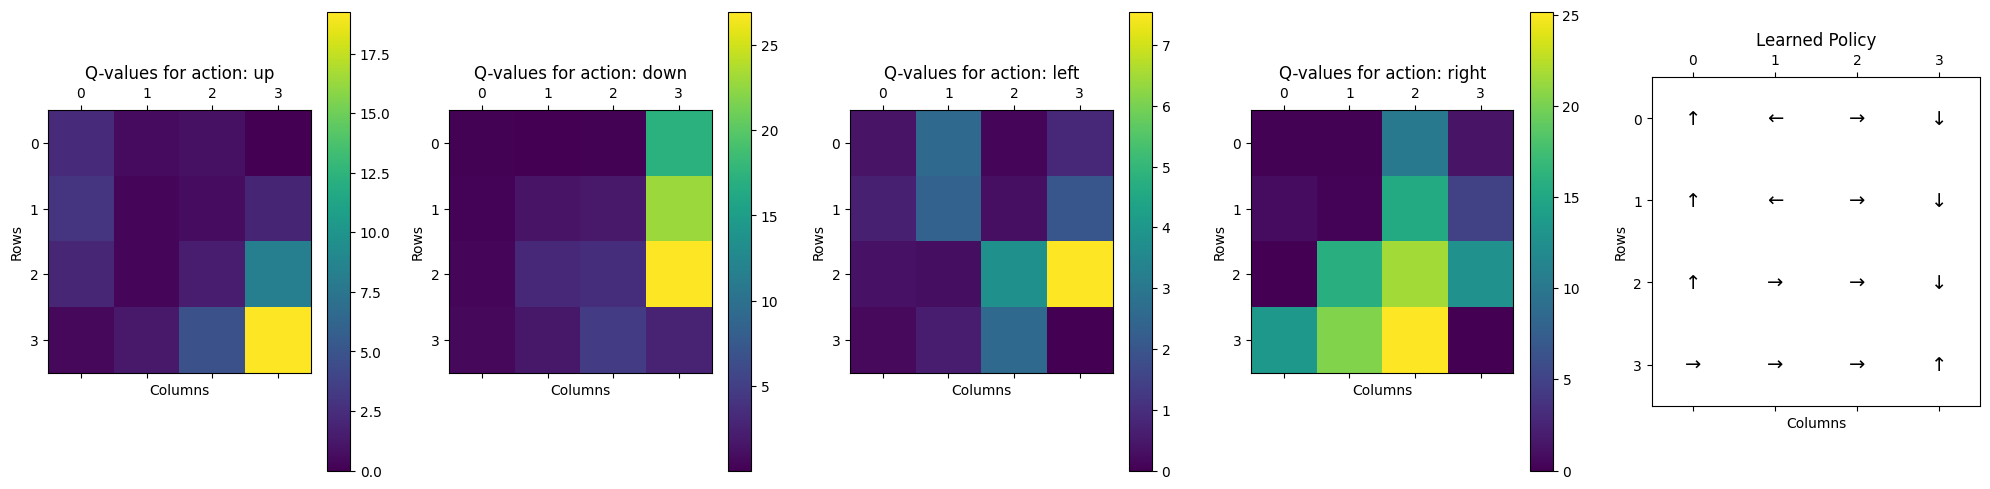

In [20]:
# Plot the Q-value heatmaps and the learned policy side by side
fig, axes = plt.subplots(1, len(action_space) + 1, figsize=(20, 5))

# Plot the Q-value heatmaps for each action
for i, action in enumerate(action_space):
    q_values = np.zeros((rows, cols))
    for (row, col), actions in q_table.items():
        q_values[row, col] = actions[action]
    cax = axes[i].matshow(q_values, cmap='viridis')
    fig.colorbar(cax, ax=axes[i])
    axes[i].set_title(f"Q-values for action: {action}")
    axes[i].set_xlabel("Columns")
    axes[i].set_ylabel("Rows")

# Plot the learned policy
policy_grid = np.empty((rows, cols), dtype=str)
action_symbols = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}
for (row, col), actions in q_table.items():
    best_action = max(actions, key=actions.get)
    policy_grid[row, col] = action_symbols[best_action]

axes[-1].matshow(np.zeros((rows, cols)), cmap='Greys', alpha=0.1)
for i in range(rows):
    for j in range(cols):
        axes[-1].text(j, i, policy_grid[i, j], ha='center', va='center', fontsize=14)
axes[-1].set_title("Learned Policy")
axes[-1].set_xlabel("Columns")
axes[-1].set_ylabel("Rows")

plt.tight_layout()
plt.show()

This visualization provides **Q-values and the learned policy** for your **4x4 GridWorld**. Let’s break it down:

**Q-value Heatmaps (Left Four Plots)**
Each heatmap represents the learned Q-values for a specific action **(up, down, left, right)** at each state in the 4x4 grid.

- **Higher Q-values (brighter colors) indicate preferred actions in those states.**
- The **"down" and "right" actions have the highest Q-values**, meaning the agent prefers to move in these directions toward the goal.
- The **bottom-right corner (goal state) has very high values in "up" and "right"**, suggesting the agent recognizes this as a valuable location.

**Learned Policy (Rightmost Plot)**
- **This shows the best action at each state** based on learned Q-values.
- The agent follows a generally **rightward and downward movement**, which makes sense if the goal is in the bottom-right.
- Some **upward arrows appear at certain positions**, suggesting the presence of obstacles or a penalty for specific movements.

**Comparison to GridWorld**
1. **Agent has mostly learned an efficient policy** (moving right/down toward the goal).
2. **Some minor inconsistencies** (like a few up/left moves) may be due to:
   - **Exploration still happening** (ε-greedy policy not fully greedy yet).
   - **Learning rate or discount factor affecting value propagation**.
   - **Possible obstacles or suboptimal reward structure**.

# Analyzing Q-Values and Optimal Policy
Let's see the optimal policy learned by the Q-learning algorithm in tabular format.

In [21]:
# Create a list of dictionaries to represent the Q-table data
q_policy_data = []
for state, actions in q_table.items():
    # Append a dictionary for each state containing Q-values for all actions and the optimal action
    q_policy_data.append({
        'State': state,  # The current state (row, col)
        'up': actions['up'],  # Q-value for the 'up' action
        'down': actions['down'],  # Q-value for the 'down' action
        'left': actions['left'],  # Q-value for the 'left' action
        'right': actions['right'],  # Q-value for the 'right' action
        'Optimal Action': max(actions, key=actions.get)  # The action with the highest Q-value
    })

# Display the Q-table data in a tabular format
header = ['State', 'up', 'down', 'left', 'right', 'Optimal Action']  # Define the table headers
# Print the table header with proper spacing
print(f"{header[0]:<10} {header[1]:<10} {header[2]:<10} {header[3]:<10} {header[4]:<10} {header[5]:<15}")
print("-" * 65)  # Print a separator line for better readability

# Iterate through the Q-table data and print each row
for row in q_policy_data:
    # Print the state, Q-values for all actions, and the optimal action
    print(f"{row['State']!s:<10} {row['up']:<10.2f} {row['down']:<10.2f} {row['left']:<10.2f} {row['right']:<10.2f} {row['Optimal Action']:<15}")


State      up         down       left       right      Optimal Action 
-----------------------------------------------------------------
(0, 0)     2.30       0.20       0.39       0.11       up             
(0, 1)     0.59       0.07       2.59       0.14       left           
(0, 2)     0.87       0.24       0.12       10.21      right          
(0, 3)     0.00       17.18      0.85       1.29       down           
(1, 0)     2.98       0.28       0.68       0.79       up             
(1, 1)     0.34       1.51       2.36       0.23       left           
(1, 2)     0.63       1.91       0.31       15.36      right          
(1, 3)     1.96       22.86      2.02       4.82       down           
(2, 0)     2.09       0.41       0.38       0.08       up             
(2, 1)     0.25       3.11       0.29       15.87      right          
(2, 2)     1.45       3.59       3.79       21.67      right          
(2, 3)     8.28       26.89      7.53       12.69      down           
(3, 0)     

**Key Observations**
1. **Different Action Preferences**  
   - The agent still moves **right and down** in many cases but now has **more left and up movements than before**.  
   - Notably, **state (0,0) prefers "up"**, while (0,1) prefers "left," which might indicate obstacles or an alternative optimal route.
  
2. **(3,3) Prefers "Up" Instead of Staying Still**  
   - If **(3,3) is a goal state**, we would expect the Q-values for other actions to be **zero** or lower due to termination.
   - Instead, "up" has a very high Q-value (19.23), meaning the agent still considers movement rather than stopping.

3. **Higher Q-values Overall**
   - The **maximum Q-values have increased** (e.g., state (2,3) has a value of 26.89 for "down").
   - This suggests **more learning has taken place**, possibly due to more training episodes or different hyperparameters (learning rate, discount factor, etc.).

4. **Potential Issues with Exploration**
   - Some moves seem **less intuitive**, such as (0,0) moving "up" rather than right.
   - This might mean **the exploration rate (ε) is still high**, causing some randomness in action selection.

**Comparison to the Policy Visualization**
- The Q-values here should match the **policy visualization arrows** (from the heatmaps you shared earlier).  
- However, if they **don't align perfectly**, it could mean:
  - The **policy is still fluctuating** due to ongoing learning.
  - There are **reward inconsistencies or obstacles** influencing Q-values.
  - Some **actions have similar Q-values**, making tie-breaking less obvious.

# Testing with Different Hyperparameters (Optional)
You can experiment with different hyperparameters to see how they affect the agent's learning process.

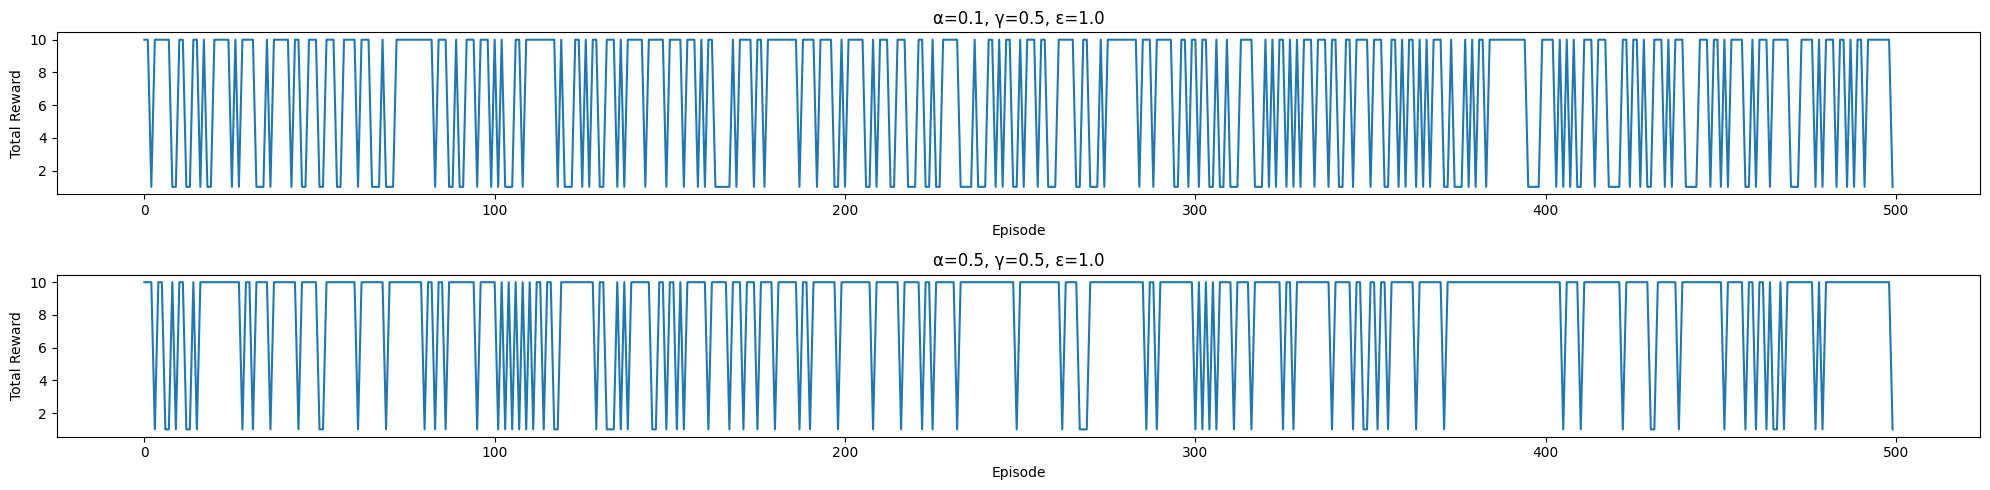

In [22]:
# Experiment with different hyperparameters
learning_rates = [0.1, 0.5]  # Different learning rates (alpha) to test
discount_factors = [0.5]  # Different discount factors (gamma) to test
exploration_rates = [1.0]  # Different initial exploration rates (epsilon) to test

# Store results for comparison
results = []

# Run experiments with different hyperparameter combinations
for alpha in learning_rates:  # Iterate over different learning rates
    for gamma in discount_factors:  # Iterate over different discount factors
        for initial_epsilon in exploration_rates:  # Iterate over different initial exploration rates
            # Initialize Q-table for the current experiment
            q_table = initialize_q_table(state_space, action_space)

            # Run Q-Learning with the current set of hyperparameters
            rewards_per_episode, episode_lengths = run_q_learning(
                q_table, state_space, action_space, rewards, rows, cols, alpha, gamma,
                initial_epsilon, min_epsilon, decay_rate, episodes, max_steps
            )

            # Store the results of the current experiment
            results.append({
                'alpha': alpha,  # Learning rate
                'gamma': gamma,  # Discount factor
                'initial_epsilon': initial_epsilon,  # Initial exploration rate
                'rewards_per_episode': rewards_per_episode,  # Rewards collected per episode
                'episode_lengths': episode_lengths  # Length of each episode
            })

# Create a larger figure to visualize all hyperparameter combinations
plt.figure(figsize=(20, 5))

# Calculate the number of rows and columns for the subplot grid
num_rows = len(learning_rates)  # Number of rows corresponds to the number of learning rates
num_cols = len(discount_factors) * len(exploration_rates)  # Number of columns corresponds to combinations of discount factors and exploration rates

# Plot the results of each experiment
for i, result in enumerate(results):  # Iterate over all results
    plt.subplot(num_rows, num_cols, i + 1)  # Create a subplot for each experiment
    plt.plot(result['rewards_per_episode'])  # Plot rewards per episode
    plt.title(f"α={result['alpha']}, γ={result['gamma']}, ε={result['initial_epsilon']}")  # Add a title with hyperparameter values
    plt.xlabel('Episode')  # Label for the x-axis
    plt.ylabel('Total Reward')  # Label for the y-axis

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

**Key Observations:**
1. **Top-Left: Rewards Over Episodes**  
   - The total reward **steadily increases**, indicating that the agent is learning a better policy over time.  
   - There are **some sudden drops** (dips to near-zero rewards), possibly due to the agent falling off the cliff (which incurs a heavy negative reward).

2. **Top-Right: Cliff Walking Grid Representation**  
   - The environment appears to be a **4-row by 12-column grid**.  
   - The **start (S)** is on the bottom-left.  
   - The **goal (G)** is on the bottom-right.  
   - The **cliff (C)**, shown in red, is along the bottom row, meaning if the agent steps there, it falls and receives a large penalty.

3. **Bottom-Left: Max Q-Values Per State**  
   - This heatmap represents the **highest Q-value for each state**.  
   - The values **increase as we move toward the goal**, which is expected.  
   - The **cliff region (row 3, columns 1-10) has very low or even negative values** (highlighted in red), showing it’s an area the agent should avoid.

4. **Bottom-Right: Learned Policy**  
   - This shows the **optimal action per state** using arrows.  
   - Most arrows point **right (→) or down (↓)**, guiding the agent toward the goal.  
   - However, in the **cliff region (bottom row)**, the arrows show a mix of left (←) and up (↑), suggesting the agent has learned to **avoid falling into the cliff**.

**Analysis:**
- The **policy is well-learned**, with the agent mostly avoiding the cliff.
- **Exploration caused early failures**, as seen in the reward dips.
- The **agent may have used Q-learning or SARSA** to solve this environment.  
  - If **Q-learning**, it learns the best long-term strategy.
  - If **SARSA**, it learns a safer policy, avoiding risky steps.